In [135]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import time

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg as qreg
import statsmodels.formula.api as smf

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

In [344]:
train = pd.read_csv('C:/Users/kcisa/Downloads/data/train/train.csv')

In [345]:
for i in range(80) :
    globals() [f'test_{i + 1}'] = pd.read_csv(f'C:/Users/kcisa/Downloads/data/test/{i}.csv')

In [346]:
### 각 데이터를 하나의 데이터로 통합
test = pd.DataFrame()
for i in range(80):
    test = pd.concat([test, globals()[f'test_{i + 1}']], axis = 0, ignore_index = True)

In [347]:
submission = pd.read_csv('C:/Users/kcisa/Downloads/data/sample_submission.csv')

In [348]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


In [349]:
test

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,2.7,34.42,0.0,0.0
1,0,0,30,0,0,2.7,34.17,0.1,0.0
2,0,1,0,0,0,2.7,34.23,0.2,0.0
3,0,1,30,0,0,2.7,33.99,0.3,0.0
4,0,2,0,0,0,2.8,33.97,0.4,0.0
...,...,...,...,...,...,...,...,...,...
26875,6,21,30,0,0,2.4,53.88,-0.5,0.0
26876,6,22,0,0,0,2.5,53.25,-0.5,0.0
26877,6,22,30,0,0,2.6,53.25,-0.5,0.0
26878,6,23,0,0,0,2.7,52.73,-0.4,0.0


In [350]:
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [351]:
train['new_day'] = train.Day % 7

In [352]:
train_after_2 = train.loc[train.Day <= 1092]

In [353]:
train_after_2['TARGET2'] = list(train.loc[train.Day >= 2].TARGET)

In [354]:
from sklearn.ensemble import RandomForestRegressor

In [355]:
X_train, X_test, y_train, y_test = train_test_split(train_after_2.drop(['TARGET2','Day'], axis = 1), train_after_2.TARGET2, test_size = 0.2, random_state=5)

In [356]:
pred_list = []
for q in np.arange(.1,1.,.1) :
    gbm = GradientBoostingRegressor(random_state = 1215, loss = 'quantile', alpha = q)
    gbm.fit(X_train, y_train)
    pred = gbm.predict(X_test)
    pred_list.append(pred)

In [357]:
gbm_pred = pd.DataFrame(pred_list).T
gbm_pred = pd.concat([gbm_pred, pd.DataFrame(y_test).reset_index().drop('index', axis = 1)], axis = 1,ignore_index = True)
gbm_pred.columns = ['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9','actual']
gbm_pred['interval'] = gbm_pred.iloc[:, 0] - gbm_pred.iloc[:,-2]

In [358]:
r2 = r2_score(gbm_pred['actual'], gbm_pred['q_0.5']).round(2)
print('R2 score is {}'.format(r2) )

R2 score is 0.77


In [359]:
def correctPcnt(df):
    correct = 0
    obs = df.shape[0]
    for i in range(obs):
        if df.loc[i,'q_0.1'] <= df.loc[i,'actual'] <= df.loc[i,'q_0.9']:
            correct += 1
    print(correct/obs)
    
correctPcnt(gbm_pred) # The result is 0.9607

0.9063184980463166


In [360]:
test.rename(columns = {'new_day' : 'Day'}, inplace = True)

In [396]:
pred_list = []
for q in np.arange(.1,1.,.1) :
    gbm = GradientBoostingRegressor(random_state = 1215, loss = 'quantile', alpha = q)
    gbm.fit(X, y)
    pred = gbm.predict(test)
    pred_list.append(pred)
pred_df = pd.DataFrame(pred_list).T
pred_df.columns = ['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9']

In [397]:
submission.iloc[:, 1:] = pred_df

In [373]:
submission.to_csv('1st.csv', index = False)

### code share

In [376]:
train = pd.read_csv('C:/Users/kcisa/Downloads/data/train/train.csv')

In [377]:
for i in range(0, 1093):
    s1 = "train_%d = pd.concat([train.loc[train['Day'] == %d].reset_index(drop = True), train.loc[train['Day'] == %d + 2].reset_index(drop = True).rename(columns = {'TARGET' : 'TARGET_2'})['TARGET_2']], axis = 1)"%(i, i, i)
    exec(s1)

In [378]:
for i in range(0,81):
    s1 = "test_%d = pd.read_csv('C:/Users/kcisa/Downloads/data/test/%d.csv')"%(i,i)
    exec(s1)

In [379]:
train_x = pd.concat([train_0, train_1], axis = 0).reset_index(drop=True)
train_x

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,TARGET_2
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
91,1,21,30,0,0,2.2,74.50,-8,0.0,0.0
92,1,22,0,0,0,2.2,72.83,-8,0.0,0.0
93,1,22,30,0,0,2.2,72.82,-8,0.0,0.0
94,1,23,0,0,0,2.2,72.51,-8,0.0,0.0


In [380]:
for i in range(2, 1093):
    s1 = "train_x = pd.concat([train_x, train_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [381]:
hour_mean = train_x.groupby(['Hour'])['TARGET'].mean()
minute_mean = train_x.groupby(['Minute'])['TARGET'].mean()
train_x['Hour_mean'] = train_x['Hour'].map(hour_mean)
train_x['Minute_mean'] = train_x['Minute'].map(minute_mean)

In [382]:
train_x = train_x.drop(['Day', 'Hour', 'Minute'], axis = 1)
train_x

,DHI,DNI,WS,RH,T,TARGET,TARGET_2,Hour_mean,Minute_mean
0,0,0,1.5,69.08,-12,0.0,0.0,0.0,17.810955
1,0,0,1.5,69.06,-12,0.0,0.0,0.0,17.799137
2,0,0,1.6,71.78,-12,0.0,0.0,0.0,17.810955
3,0,0,1.6,71.75,-12,0.0,0.0,0.0,17.799137
4,0,0,1.6,75.20,-12,0.0,0.0,0.0,17.810955
...,...,...,...,...,...,...,...,...,...
52459,0,0,3.5,55.97,-1,0.0,0.0,0.0,17.799137
52460,0,0,3.9,54.23,-2,0.0,0.0,0.0,17.810955
52461,0,0,4.1,54.21,-2,0.0,0.0,0.0,17.799137
52462,0,0,4.3,56.46,-2,0.0,0.0,0.0,17.810955


In [383]:
x_train = train_x.drop(['TARGET_2'], axis = 1)
y_train = train_x['TARGET_2']

In [384]:
x_train

,DHI,DNI,WS,RH,T,TARGET,Hour_mean,Minute_mean
0,0,0,1.5,69.08,-12,0.0,0.0,17.810955
1,0,0,1.5,69.06,-12,0.0,0.0,17.799137
2,0,0,1.6,71.78,-12,0.0,0.0,17.810955
3,0,0,1.6,71.75,-12,0.0,0.0,17.799137
4,0,0,1.6,75.20,-12,0.0,0.0,17.810955
...,...,...,...,...,...,...,...,...
52459,0,0,3.5,55.97,-1,0.0,0.0,17.799137
52460,0,0,3.9,54.23,-2,0.0,0.0,17.810955
52461,0,0,4.1,54.21,-2,0.0,0.0,17.799137
52462,0,0,4.3,56.46,-2,0.0,0.0,17.810955


In [385]:
for i in range(0, 81):
    s1 = "test_%d = test_%d[240:].reset_index(drop = True)"%(i,i)
    s2 = "hour_mean = test_%d.groupby(['Hour'])['TARGET'].mean()"%(i)
    s3 = "minute_mean = test_%d.groupby(['Minute'])['TARGET'].mean()"%(i)
    s4 = "test_%d['Hour_mean'] = test_%d['Hour'].map(hour_mean)"%(i,i)
    s5 = "test_%d['Minute_mean'] = test_%d['Minute'].map(minute_mean)"%(i,i)
    s6 = "test_%d = test_%d.drop(['Day', 'Hour', 'Minute'], axis = 1)"%(i,i)
    exec(s1)
    exec(s2)
    exec(s3)
    exec(s4)
    exec(s5)
    exec(s6)

In [386]:
test_x = pd.concat([test_0, test_1], axis = 0).reset_index(drop=True)
test_x

,DHI,DNI,WS,RH,T,TARGET,Hour_mean,Minute_mean
0,0,0,2.1,52.83,-4.4,0.0,0.0,6.061008
1,0,0,2.0,54.44,-4.8,0.0,0.0,5.926100
2,0,0,1.9,52.78,-5.1,0.0,0.0,6.061008
3,0,0,1.8,53.59,-5.3,0.0,0.0,5.926100
4,0,0,1.7,52.63,-5.5,0.0,0.0,6.061008
...,...,...,...,...,...,...,...,...
187,0,0,1.7,43.65,-5.2,0.0,0.0,11.308777
188,0,0,1.5,40.62,-4.9,0.0,0.0,11.297040
189,0,0,1.5,40.62,-4.9,0.0,0.0,11.308777
190,0,0,1.5,39.21,-4.9,0.0,0.0,11.297040


In [387]:
for i in range(2, 81):
    s1 = "test_x = pd.concat([test_x, test_%d], axis = 0).reset_index(drop = True)"%(i)
    exec(s1)

In [388]:
x_test = test_x.copy()

In [389]:
def linear_reg(X,y):
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

#X변수 개수
m = len(y_train)
k = 8
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#1 ~ 8까지 모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(x_train.columns) + 1):
    for combo in itertools.combinations(x_train.columns,k):
        tmp_result = linear_reg(x_train[list(combo)],y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [390]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,1.762009e+07,0.494386,"(DHI,)",1.058685e+07,0.696207
1,1,2.235501e+07,0.358516,"(DNI,)",1.058685e+07,0.696207
2,1,3.281036e+07,0.058496,"(WS,)",1.058685e+07,0.696207
3,1,2.265496e+07,0.349909,"(RH,)",1.058685e+07,0.696207
4,1,2.578791e+07,0.260008,"(T,)",1.058685e+07,0.696207


In [391]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
display(df_min.head(5))

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
6,1,1.058685e+07,0.696207,"(Hour_mean,)",1.058685e+07,0.696207
33,2,8.892195e+06,0.744836,"(TARGET, Hour_mean)",8.892195e+06,0.744836
69,3,8.319371e+06,0.761273,"(DNI, TARGET, Hour_mean)",8.319371e+06,0.761273
143,4,8.105550e+06,0.767409,"(DNI, T, TARGET, Hour_mean)",8.105550e+06,0.767409
178,5,8.092551e+06,0.767782,"(DHI, DNI, T, TARGET, Hour_mean)",8.092551e+06,0.767782


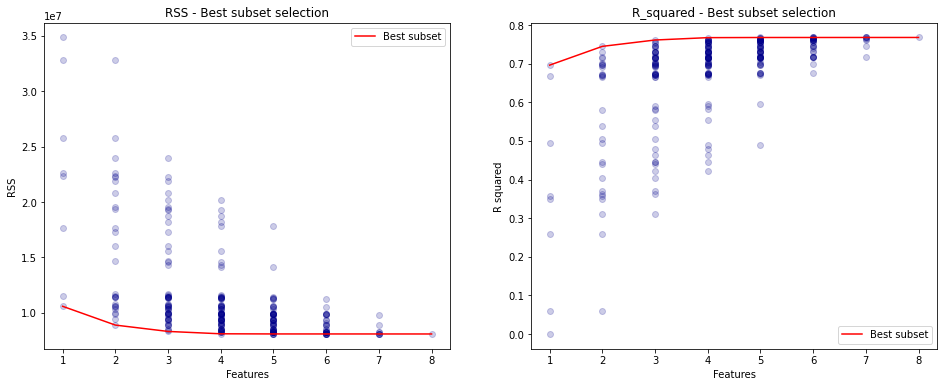

In [392]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

In [393]:
submission['q_0.1'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.1).predict(x_test['Hour_mean'])
submission['q_0.2'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.2).predict(x_test['Hour_mean'])
submission['q_0.3'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.3).predict(x_test['Hour_mean'])
submission['q_0.4'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.4).predict(x_test['Hour_mean'])
submission['q_0.5'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.5).predict(x_test['Hour_mean'])
submission['q_0.6'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.6).predict(x_test['Hour_mean'])
submission['q_0.7'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.7).predict(x_test['Hour_mean'])
submission['q_0.8'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.8).predict(x_test['Hour_mean'])
submission['q_0.9'] = qreg(y_train, x_train['Hour_mean']).fit(q=0.9).predict(x_test['Hour_mean'])

In [394]:
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [395]:
submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,3.907829,8.348947,11.933091,14.651753,17.290594,20.735159,24.056555,27.111178,30.213244
std,5.386614,11.508323,16.448765,20.196211,23.833632,28.581677,33.159941,37.370483,41.646420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.227190,0.485384,0.693756,0.851811,1.005226,1.205483,1.398580,1.576167,1.756512
75%,7.110587,15.191532,21.713149,26.659956,31.461524,37.729168,43.772695,49.330809,54.975249
max,20.876801,44.602592,63.750171,78.274078,92.371563,110.773472,128.517366,144.836083,161.408254


In [398]:
submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,0.676624,0.686961,0.693865,0.698991,0.700525,0.704722,0.718084,0.724234,0.758203
std,0.706807,0.717584,0.723818,0.728185,0.729662,0.733869,0.743363,0.750397,0.710034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000032,0.000038,0.000045,0.026914
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000032,0.000038,0.000045,0.111460
50%,0.271512,0.271119,0.342200,0.326866,0.286627,0.307302,0.351658,0.349164,0.357370
75%,1.442024,1.487717,1.497538,1.504396,1.510883,1.503480,1.530735,1.564561,1.536132
max,1.649038,1.672392,1.691562,1.698553,1.715012,1.729411,1.723095,1.723112,1.723691


In [428]:
test

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,2.7,34.42,0.0,0.0
1,0,0,30,0,0,2.7,34.17,0.1,0.0
2,0,1,0,0,0,2.7,34.23,0.2,0.0
3,0,1,30,0,0,2.7,33.99,0.3,0.0
4,0,2,0,0,0,2.8,33.97,0.4,0.0
...,...,...,...,...,...,...,...,...,...
26875,6,21,30,0,0,2.4,53.88,-0.5,0.0
26876,6,22,0,0,0,2.5,53.25,-0.5,0.0
26877,6,22,30,0,0,2.6,53.25,-0.5,0.0
26878,6,23,0,0,0,2.7,52.73,-0.4,0.0


In [426]:
def pb_loss(true, pred, q) :
    L_q = list(true - pred)
    L_q *= np.array([q] * 4)
    return L_q

In [418]:
list(np.array([1,2,3,4]) - np.array([4,3,2,2])) * np.array([.1] * 4)

array([-0.3, -0.1,  0.1,  0.2])

In [427]:
pb_loss(np.array([4,5,6,1]), np.array([2,3,4,1]), .1)

array([0.2, 0.2, 0.2, 0. ])

0.2